<a href="https://colab.research.google.com/github/jean0527/ds_final_project_shelter/blob/main/DS_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

file_path = '/content/drive/MyDrive/DS_final/dog_shelter.xlsx'
test_data = pd.ExcelFile(file_path).parse('\u8a73\u7d30\u6578\u64da')

detailed_data = pd.read_excel('/content/drive/MyDrive/DS_final/dogs_combined.xlsx')
print(detailed_data.head())


       county_city  Year  Month  mortality_rate  containment_rate  \
0  New Taipei City   113      1            0.02          0.621554   
1  New Taipei City   113      2            0.06          0.605514   
2  New Taipei City   113      3            0.01          0.607519   
3  New Taipei City   113      4            0.01          0.636090   
4  New Taipei City   113      5            0.01          0.615539   

   adoption_rate    county_city.1  Year.1  Month.1  mortality_rate.1  ...  \
0           0.84  New Taipei City     113        1              0.02  ...   
1           1.05  New Taipei City     113        2              0.06  ...   
2           0.95  New Taipei City     113        3              0.01  ...   
3           0.82  New Taipei City     113        4              0.01  ...   
4           1.06  New Taipei City     113        5              0.01  ...   

   Month.2  mortality_rate.2 containment_rate.2  adoption_rate.2  \
0        1              0.02           0.621554       



---



#Step 1: Data Cleaning and EDA

Outliers in containment_rate:
           county_city  Year  Month  mortality_rate  containment_rate  \
320   Pingtung County   112      8            0.03          1.836957   
392       Taipei City   112      8            0.06          1.826230   
394       Taipei City   112     10            0.08          1.821311   
1094  Changhua County   109      2            0.06          1.846154   
1177    Penghu County   109      1            0.00          1.968750   
1178    Penghu County   109      2            0.52          2.321429   
1179    Penghu County   109      3            0.42          2.112500   
1180    Penghu County   109      4            0.62          2.150000   
1181    Penghu County   109      5            0.69          1.912500   
1182    Penghu County   109      6            0.76          1.850000   
1214      Taipei City   109      2            0.10          2.317778   
1218      Taipei City   109      6            0.07          1.832787   
1219      Taipei City   109      

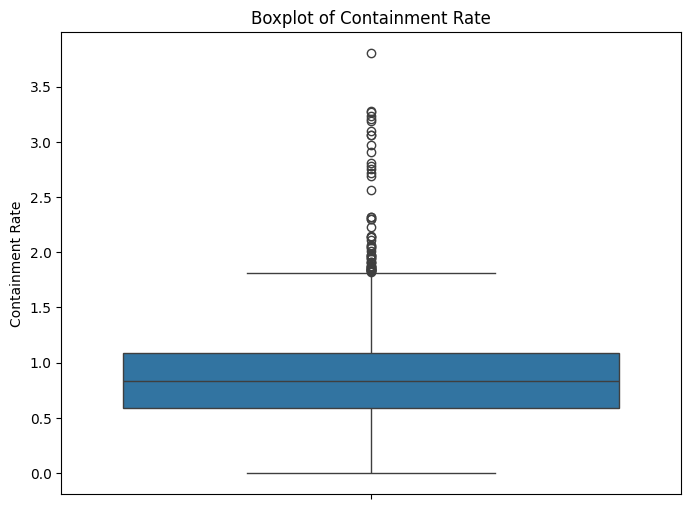

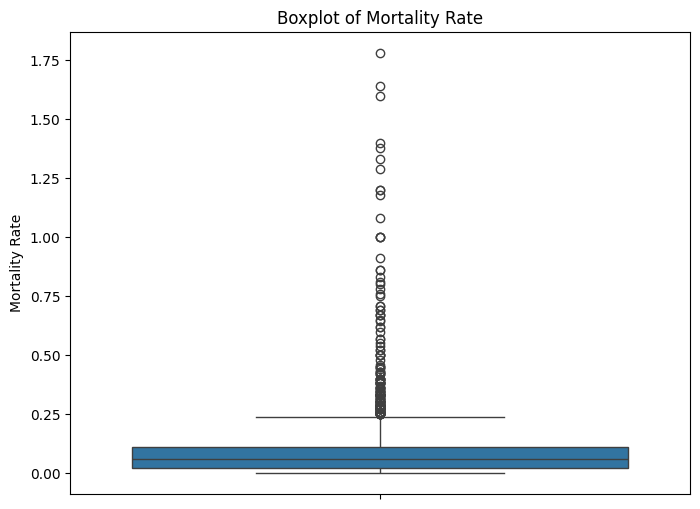

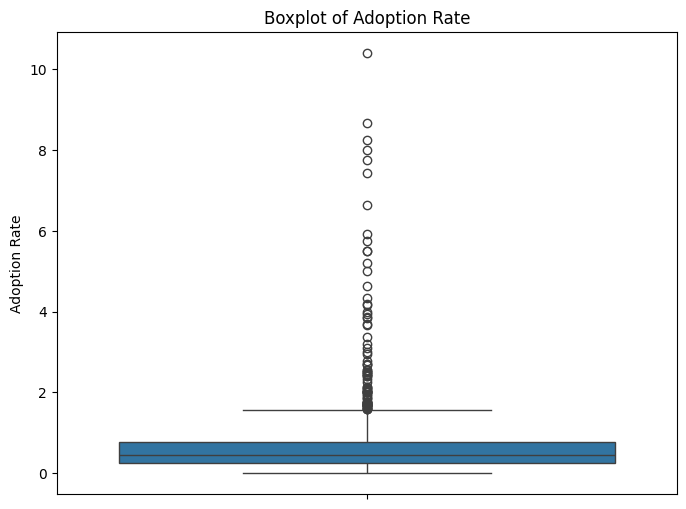

<ipython-input-6-afa4eff44cd8>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detailed_data['Year'] = detailed_data['Year'].astype(int)
<ipython-input-6-afa4eff44cd8>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detailed_data['Month'] = detailed_data['Month'].astype(int)


In [ ]:
#remove outliers
outliers = {}
numeric_cols = ['containment_rate', 'mortality_rate', 'adoption_rate']  # List of numeric columns

for col in numeric_cols:
    Q1 = detailed_data[col].quantile(0.25)
    Q3 = detailed_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = detailed_data[(detailed_data[col] < lower_bound) | (detailed_data[col] > upper_bound)]

for col, df in outliers.items():
    print(f"Outliers in {col}:\n", df)

for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=detailed_data[col])
    plt.title(f"Boxplot of {col.replace('_', ' ').title()}")
    plt.ylabel(col.replace('_', ' ').title())
    plt.show()


numerical_columns = detailed_data.select_dtypes(include=['float64', 'int64']).columns
detailed_data[numerical_columns] = detailed_data[numerical_columns].fillna(detailed_data[numerical_columns].mean())

#remove Lianjang County
filtered_data = detailed_data[detailed_data['county_city'] != "Lianjiang County"]
detailed_data = filtered_data

detailed_data['Year'] = detailed_data['Year'].astype(int)
detailed_data['Month'] = detailed_data['Month'].astype(int)


In [ ]:
remaining_missing = detailed_data.isnull().sum()
print("Remaining Missing Data:")
print(remaining_missing[remaining_missing > 0])


Remaining Missing Data:
Series([], dtype: int64)


In [ ]:
# Dummy variables
dummies = pd.get_dummies(detailed_data['county_city'], prefix='county_city', drop_first=True)
detailed_data = pd.concat([detailed_data, dummies], axis=1)

# Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define features and target
X = detailed_data[['containment_rate'] + list(dummies.columns)]
y = detailed_data['mortality_rate']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Predict on the test set
y_pred = reg.predict(X_test)

# Calculate and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Print all model coefficients
print("Model Coefficients:", reg.coef_)

# Extract and print the coefficient for containment_rate
containment_rate_coef = reg.coef_[0]  # the first coefficient in the list corresponds to 'containment_rate'
print("Coefficient for Containment Rate:", containment_rate_coef)

# # @title
# # Dummy variables
# dummies = pd.get_dummies(detailed_data['county_city'], prefix='county_city', drop_first=True)
# detailed_data = pd.concat([detailed_data, dummies], axis=1)

# #Regression Model
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

# X = detailed_data[['containment_rate'] + list(dummies.columns)]
# y = detailed_data['mortality_rate']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# reg = LinearRegression()
# reg.fit(X_train, y_train)

# y_pred = reg.predict(X_test)
# print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
# print("Model Coefficients:", reg.coef_)


Mean Squared Error: 0.0197672749307188
Model Coefficients: [ 0.00768715  0.10044819  0.02612542  0.03724786  0.03054995 -0.01848178
 -0.02395075  0.06880426 -0.01476442  0.03451724  0.02497621 -0.01991036
  0.17258037  0.09121976  0.02741796  0.02019268  0.01569657  0.00369104
 -0.01220635  0.00647847  0.25395202  0.00392027]
Coefficient for Containment Rate: 0.00768715169941142


In [ ]:
detailed_data.head()

,county_city,Year,Month,mortality_rate,containment_rate,adoption_rate,county_city.1,Year.1,Month.1,mortality_rate.1,...,county_city_Penghu County,county_city_Pingtung County,county_city_Taichung City,county_city_Tainan City,county_city_Taipei City,county_city_Taitung County,county_city_Taoyuan City,county_city_Yilan County,county_city_Yunlin County,county_city_total
0,New Taipei City,113,1,0.02,0.621554,0.84,New Taipei City,113,1,0.02,...,False,False,False,False,False,False,False,False,False,False
1,New Taipei City,113,2,0.06,0.605514,1.05,New Taipei City,113,2,0.06,...,False,False,False,False,False,False,False,False,False,False
2,New Taipei City,113,3,0.01,0.607519,0.95,New Taipei City,113,3,0.01,...,False,False,False,False,False,False,False,False,False,False
3,New Taipei City,113,4,0.01,0.636090,0.82,New Taipei City,113,4,0.01,...,False,False,False,False,False,False,False,False,False,False
4,New Taipei City,113,5,0.01,0.615539,1.06,New Taipei City,113,5,0.01,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
#detailed_data=detailed_data.drop(columns=['county_city'])

#Step 2: Initial Observations
### Let's see how well our topic ties up by visualizing the relationship between:
containment_rate;	mortality_rate &	adoption_rate


# Calculate correlation coefficients

In [ ]:
correlation_adoption, p_value_adoption = pearsonr(detailed_data['adoption_rate'], detailed_data['mortality_rate'])
correlation_containment, p_value_containment = pearsonr(detailed_data['containment_rate'], detailed_data['mortality_rate'])

print(f"Adoption Rate vs Mortality Rate: Correlation = {correlation_adoption}, P-value = {p_value_adoption}")
print(f"Containment Rate vs Mortality Rate: Correlation = {correlation_containment}, P-value = {p_value_containment}")


Adoption Rate vs Mortality Rate: Correlation = 0.2244005791677041, P-value = 2.828806312372242e-22
Containment Rate vs Mortality Rate: Correlation = 0.14643197449161374, P-value = 3.23822337765203e-10


Observations:

Adoption Rate vs Mortality Rate:

- Indicates a weak positive correlation between adoption rate and mortality rate.
- The p-value is highly significant (< 0.001). This means the correlation is unlikely to be due to chance, and there is statistical evidence of a relationship between adoption rates and mortality rates.
- A weak but statistically significant relationship suggests that increasing adoption rates may slightly influence mortality, potentially due to indirect factors such as resource strain or disease transmission during adoption processes.

Containment Rate vs Mortality Rate:

- Indicates a weak positive correlation compared to adoption rate and mortality rate.
- This suggests that higher containment rates have a minor influence on mortality rates. The relationship is very weak.
- The p-value is highly significant, suggesting a non-random relationship.
- This implies containment rates may have a minor but consistent effect on mortality, though additional factors are likely more influential.

# Scatter plot: Adoption Rate vs Mortality Rate

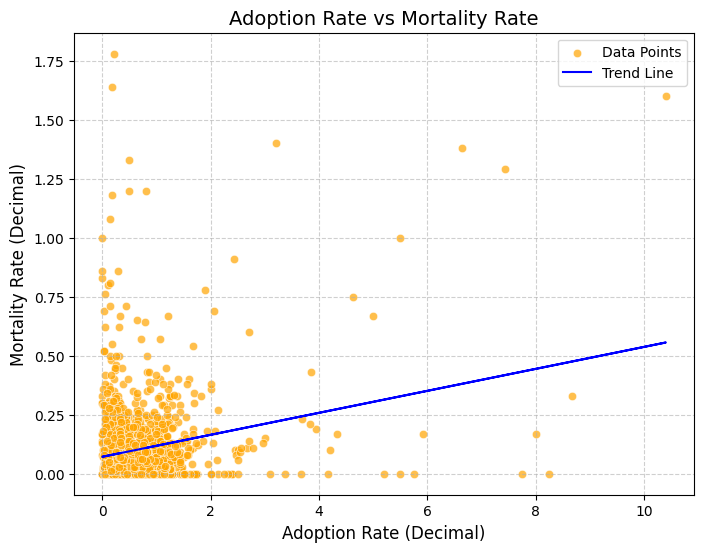

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='adoption_rate', y='mortality_rate', data=detailed_data, color='orange', alpha=0.7, label='Data Points')
z = np.polyfit(detailed_data['adoption_rate'], detailed_data['mortality_rate'], 1)
p = np.poly1d(z)
plt.plot(detailed_data['adoption_rate'], p(detailed_data['adoption_rate']), color='blue', label='Trend Line')
plt.title('Adoption Rate vs Mortality Rate', fontsize=14)
plt.xlabel('Adoption Rate (Decimal)', fontsize=12)
plt.ylabel('Mortality Rate (Decimal)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Observation:
- A slight upward trend is visible, suggesting a weak positive correlation between adoption rate and mortality rate.
- As the adoption rate increases, mortality rates tend to increase slightly, as supported by the correlation coefficient (0.173).
- There is significant variability, indicating that other factors may have a stronger influence on mortality rates.

# Scatter plot: Containment Rate vs Mortality Rate

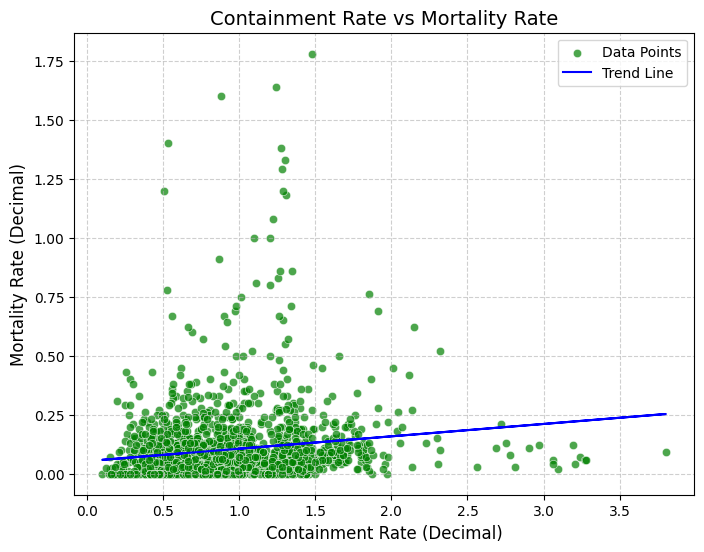

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='containment_rate', y='mortality_rate', data=detailed_data, color='green', alpha=0.7, label='Data Points')
z_cont = np.polyfit(detailed_data['containment_rate'], detailed_data['mortality_rate'], 1)
p_cont = np.poly1d(z_cont)
plt.plot(detailed_data['containment_rate'], p_cont(detailed_data['containment_rate']), color='blue', label='Trend Line')
plt.title('Containment Rate vs Mortality Rate', fontsize=14)
plt.xlabel('Containment Rate (Decimal)', fontsize=12)
plt.ylabel('Mortality Rate (Decimal)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Observation
- A stronger upward trend compared to adoption rates, indicating that higher containment rates are more closely associated with higher mortality rates.
- This aligns with the hypothesis that overcrowding in shelters can lead to stress, resource strain, and increased mortality.
- This correlation is significant, emphasizing the importance of managing shelter capacity to improve animal welfare.

# Pairplot for all variables

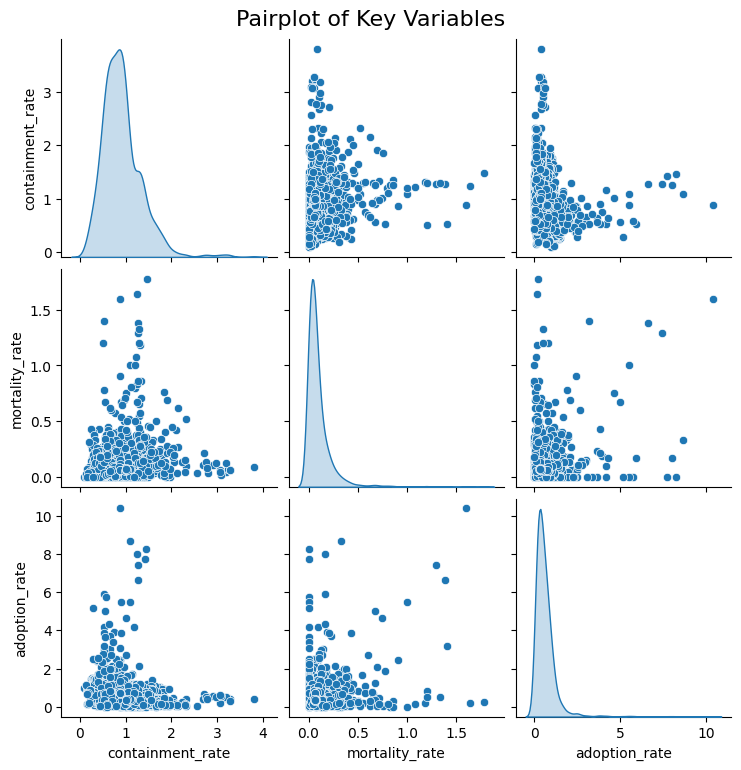

In [ ]:
sns.pairplot(detailed_data, vars=['containment_rate', 'mortality_rate', 'adoption_rate'], diag_kind='kde')
plt.suptitle('Pairplot of Key Variables', y=1.02, fontsize=16)
plt.show()

Observation:
- The scatter plots confirm the weak correlation between adoption rate and mortality rate, and the stronger correlation between containment rate and mortality rate.
- Distributions of individual variables:
 - Mortality Rate: Skewed toward lower values, with a few outliers (high mortality rates in some shelters).
 - Adoption Rate: Broad distribution, with some shelters achieving very high adoption rates.
 - Containment Rate: Mostly clustered at moderate levels, with fewer shelters at extreme overcapacity.

# Heatmap of correlations

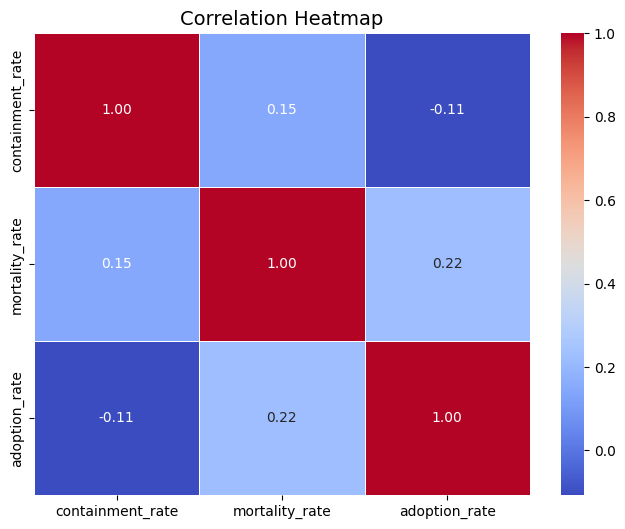

In [ ]:
correlation_matrix = detailed_data[['containment_rate', 'mortality_rate', 'adoption_rate']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=14)
plt.show()

Observation:
- Containment Rate vs. Mortality Rate: A weak positive correlation (~0.09). This confirms the hypothesis that overcrowding in shelters is a minor driver of mortality.
- Adoption Rate vs. Mortality Rate: A weak positive correlation (~0.17). This suggests As adoption rates increase, mortality rates tend to rise slightly.
- Containment Rate vs. Adoption Rate: A weak negative correlation (~-0.21), higher containment rates are slightly associated with lower adoption rates.



---


#Step 3: Detailed observations:
### Lets take it a step further by identifying whether mortality rates significantly differ across levels of containment or adoption.

# Regression Plot

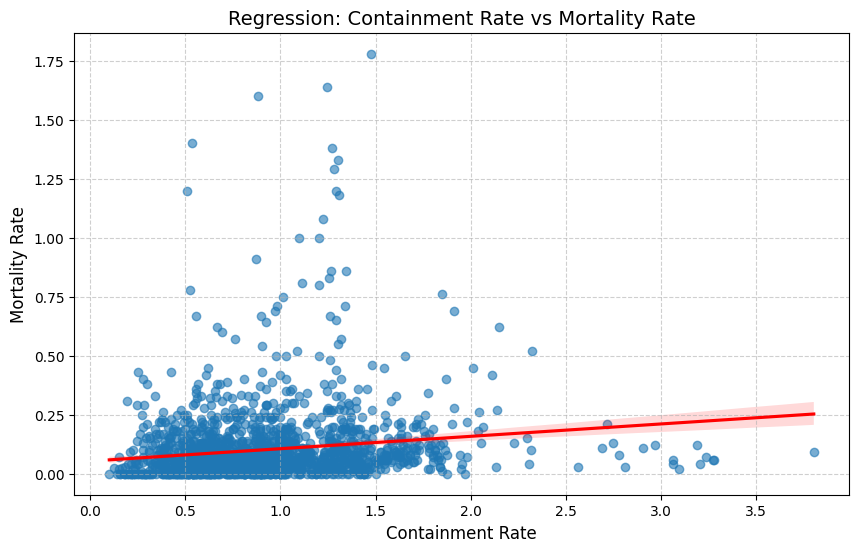

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(x='containment_rate', y='mortality_rate', data=detailed_data, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
plt.title('Regression: Containment Rate vs Mortality Rate', fontsize=14)
plt.xlabel('Containment Rate', fontsize=12)
plt.ylabel('Mortality Rate', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Observations:

- The regression line has a positive slope, confirming that higher containment rates are associated with higher mortality rates.

- While the trend is clear, the points are scattered around the line, indicating variability, which indicates that containment rate is not the sole factor affecting mortality.

- Variations in mortality rates at similar containment levels suggest that shelter management, health practices, and resources also influence outcomes.


# Mortality Rate By Containment Rate Levels Boxplot

<ipython-input-44-a2d22f45132b>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='containment_rate_bin', y='mortality_rate', data=detailed_data, palette='Set2')


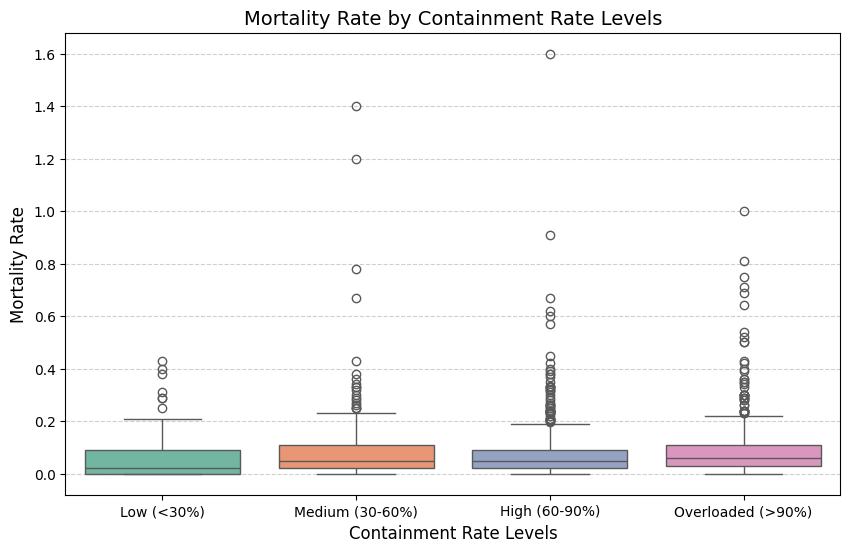

In [ ]:
import seaborn as sns

detailed_data['containment_rate_bin'] = pd.cut(
    detailed_data['containment_rate'],
    bins=[0, 0.3, 0.6, 0.9, 1.2],
    labels=['Low (<30%)', 'Medium (30-60%)', 'High (60-90%)', 'Overloaded (>90%)']
)

plt.figure(figsize=(10, 6))
sns.boxplot(x='containment_rate_bin', y='mortality_rate', data=detailed_data, palette='Set2')
plt.title('Mortality Rate by Containment Rate Levels', fontsize=14)
plt.xlabel('Containment Rate Levels', fontsize=12)
plt.ylabel('Mortality Rate', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


Observations:

Mortality Rates Increase with Containment Levels:

- Low (<30%): Mortality rates relatively higher at the median compared to other categories.
 - This might indicate that shelters with lower containment rates could still face challenges, such as resource scarcity or other inefficiencies, despite not being overcrowded.
- Medium (30-60%): This category shows the lowest median mortality rate.
 - Indicates that shelters operating within this range are likely functioning optimally, balancing containment and resource availability effectively.

- High (60-90%): Slightly increased median and spread compared to the medium category.
 - Indicates that overcrowding starts to have a noticeable impact on mortality rates as shelters approach capacity.
- Overloaded (>90%): Mortality rates increase in median and spread, showing the impact of severe overcrowding.
 - Higher variability and outliers indicate that some shelters may manage overcrowding better, while others struggle significantly.


Outliers:

- All categories exhibit outliers, but the overloaded category (>90%) has the most extreme outliers. These could represent shelters facing severe challenges like disease outbreaks or operational inefficiencies.

# Heatmap of Monthly Averages

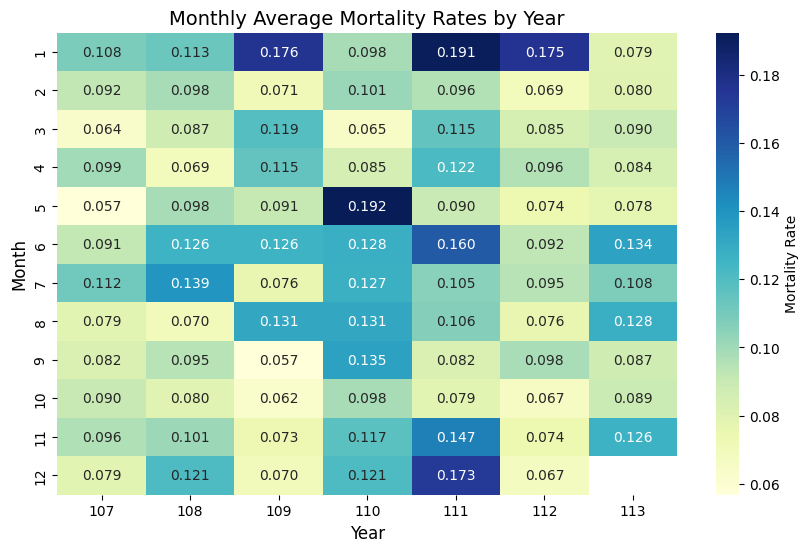

In [ ]:
numeric_data = detailed_data.drop(columns=['county_city', 'containment_rate_bin'], errors='ignore')
monthly_averages = numeric_data.groupby(['Year', 'Month']).mean(numeric_only=True).reset_index()
heatmap_data = monthly_averages.pivot_table(index='Month', columns='Year', values='mortality_rate')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='YlGnBu', cbar_kws={'label': 'Mortality Rate'})
plt.title('Monthly Average Mortality Rates by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.show()


Observations:

- The heatmap shows monthly trends in mortality rates, with some months (e.g., January) having slightly higher averages compared to others.
- This can indicate seasonal factors, such as increased intake during colder months, leading to resource constraints and higher mortality rates.

- Consistency:
The differences in mortality rates across months are generally small, but the visualization highlights subtle trends that could guide resource planning.



---



#Step 4: Regression plot by county branch
let's do some analysis on individual branches to see if there is any resource allocation issue or any difference in treatment by individual

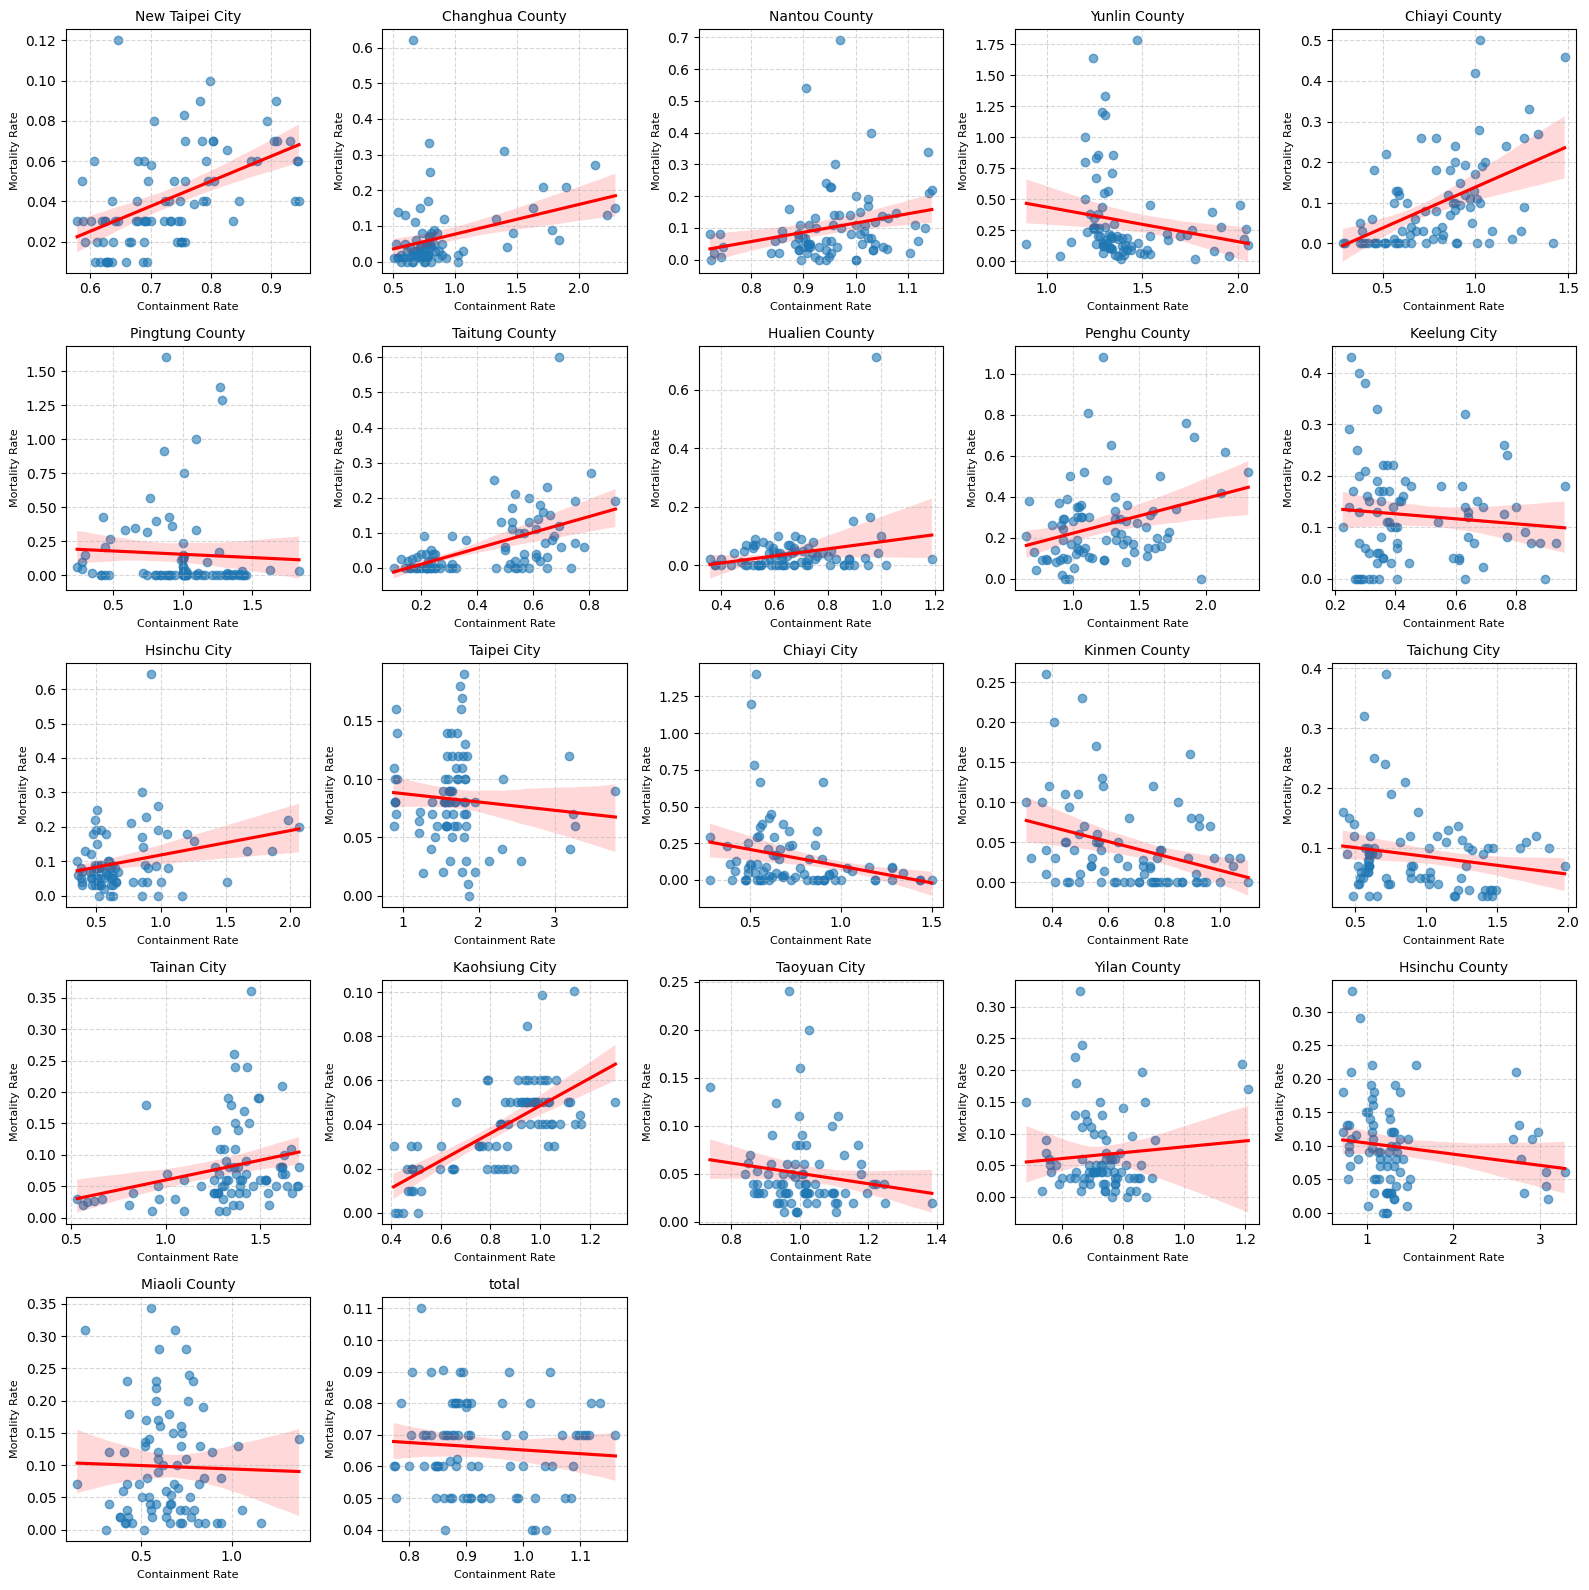

In [ ]:
counties = detailed_data['county_city'].unique()

num_counties = len(counties)
grid_size = int(np.ceil(np.sqrt(num_counties)))

plt.figure(figsize=(16, 16))
for idx, county in enumerate(counties, 1):
    plt.subplot(grid_size, grid_size, idx)
    county_data = detailed_data[detailed_data['county_city'] == county]
    sns.regplot(
        x='containment_rate',
        y='mortality_rate',
        data=county_data,
        scatter_kws={'alpha': 0.6},
        line_kws={'color': 'red'},
    )
    plt.title(county, fontsize=10)
    plt.xlabel('Containment Rate', fontsize=8)
    plt.ylabel('Mortality Rate', fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

observations:
- Positive Trends in some Counties such as New Taipei City, Hualien County, and Tainan City between containment rate and mortality rate. This suggests that overcrowding in shelters in these areas is strongly associated with increased mortality.

- Negative or Inconsistent Trends in Counties such as Nantou County, Keelung City, and Chiayi City exhibit negative or weak relationships. This could indicate better shelter management or additional resources mitigating the impact of overcrowding on mortality.

- Negative or No Trend in Counties like Nantou County, Chiayi City, and Keelung City exhibit weak or negative trends, suggesting that containment rates are not the primary factor affecting mortality in these areas.

- Several counties (e.g., Yunlin County, Taoyuan City) show significant outliers with high mortality rates at varying containment levels, warranting investigation.

- Overall, the "total" plot shows a slight positive trend, indicating that on average, higher containment rates lead to higher mortality rates across all counties. However, the degree of this impact varies significantly by region.



---



#Step 5: Euthanasia vs natural causes

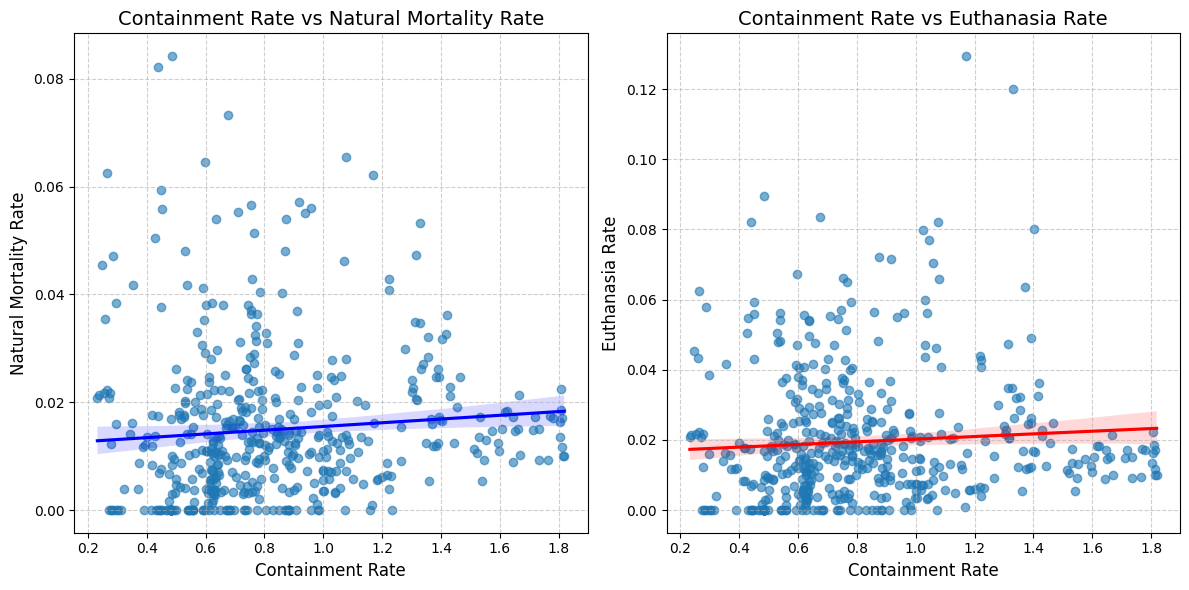

In [ ]:
plt.figure(figsize=(12, 6))

# Natural Mortality
plt.subplot(1, 2, 1)
sns.regplot(
    x='containment_rate',
    y='mortality_rate',
    data=test_data,
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'blue'}
)
plt.title('Containment Rate vs Natural Mortality Rate', fontsize=14)
plt.xlabel('Containment Rate', fontsize=12)
plt.ylabel('Natural Mortality Rate', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Euthanasia
plt.subplot(1, 2, 2)
sns.regplot(
    x='containment_rate',
    y='euthanasia_rate',
    data=test_data,
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
)
plt.title('Containment Rate vs Euthanasia Rate', fontsize=14)
plt.xlabel('Containment Rate', fontsize=12)
plt.ylabel('Euthanasia Rate', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()



---



#Step 6: Identifying trends

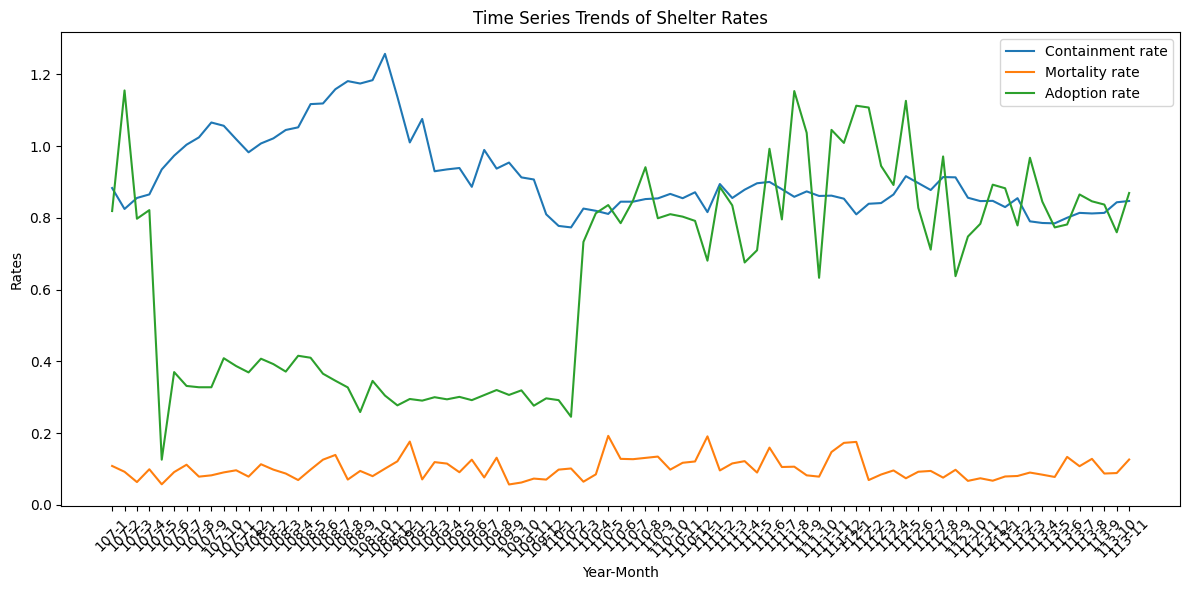

In [ ]:
# 1. Time Series Trends: Aggregate by year-month and calculate averages
time_series_data = (
    detailed_data.groupby(['Year', 'Month'])
    [['containment_rate', 'mortality_rate', 'adoption_rate']].mean().reset_index()
)

# Plot time series trends for each metric
plt.figure(figsize=(12, 6))
for col in ['containment_rate', 'mortality_rate', 'adoption_rate']:
    plt.plot(time_series_data['Year'].astype(str) + '-' + time_series_data['Month'].astype(str),
             time_series_data[col], label=col.capitalize().replace('_', ' '))

plt.title('Time Series Trends of Shelter Rates')
plt.xlabel('Year-Month')
plt.ylabel('Rates')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

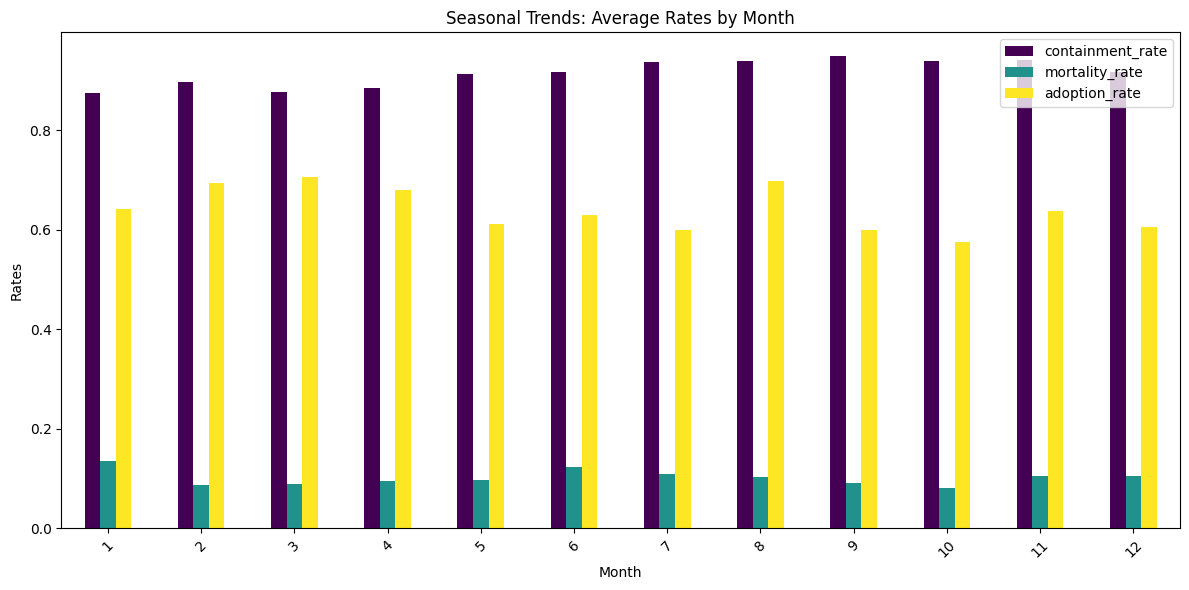

In [ ]:
# 2. Seasonal Analysis
monthly_averages = detailed_data.groupby('Month')[['containment_rate', 'mortality_rate', 'adoption_rate']].mean()

# Plot seasonal trends
plt.figure(figsize=(10, 6))
monthly_averages.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Seasonal Trends: Average Rates by Month')
plt.xlabel('Month')
plt.ylabel('Rates')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



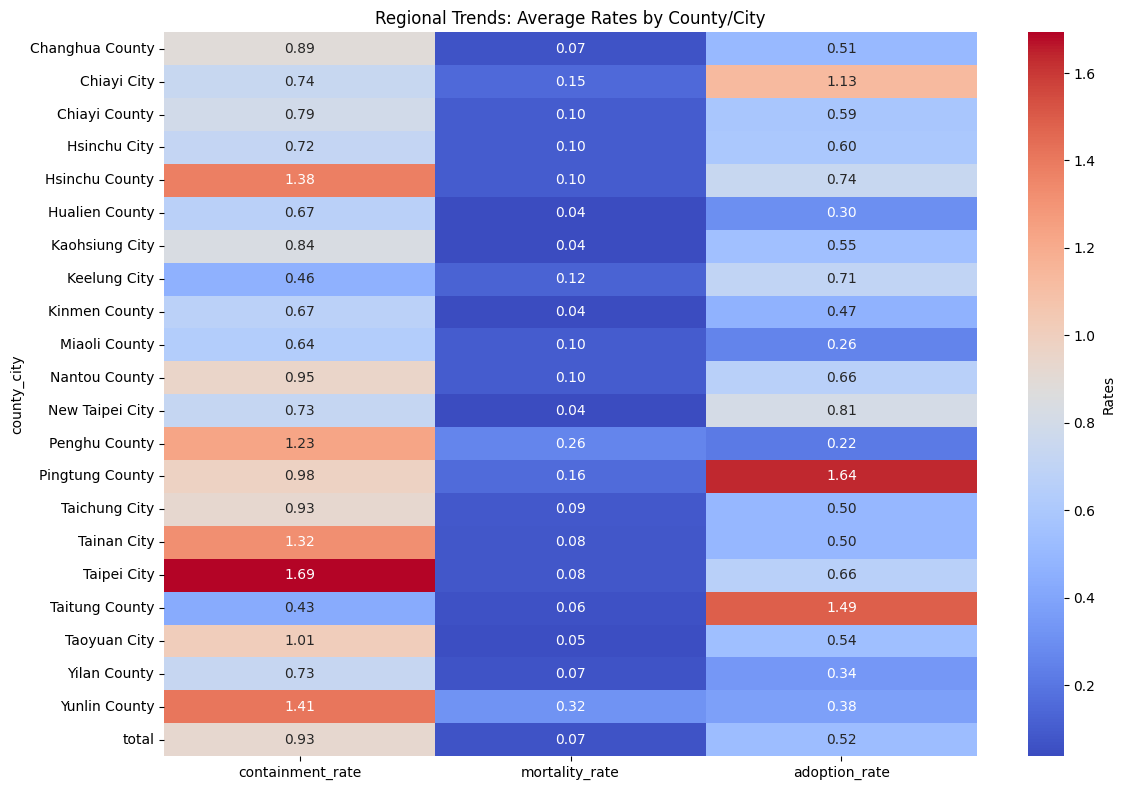

In [ ]:
# 3. Regional Trends
regional_averages = (
    detailed_data.groupby('county_city')[['containment_rate', 'mortality_rate', 'adoption_rate']].mean()
)

# Heatmap of regional averages
plt.figure(figsize=(12, 8))
sns.heatmap(regional_averages, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Rates'})
plt.title('Regional Trends: Average Rates by County/City')
plt.tight_layout()
plt.show()

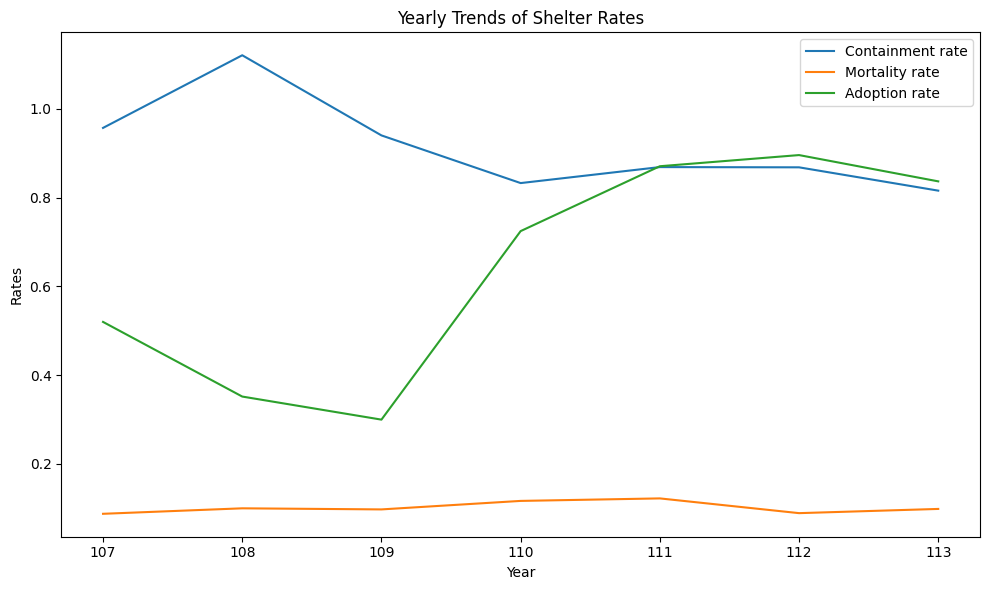

In [ ]:
# 4. Trends by Year
yearly_averages = detailed_data.groupby('Year')[['containment_rate', 'mortality_rate', 'adoption_rate']].mean()

# Line plot for yearly trends
plt.figure(figsize=(10, 6))
for col in ['containment_rate', 'mortality_rate', 'adoption_rate']:
    plt.plot(yearly_averages.index, yearly_averages[col], label=col.capitalize().replace('_', ' '))

plt.title('Yearly Trends of Shelter Rates')
plt.xlabel('Year')
plt.ylabel('Rates')
plt.legend()
plt.tight_layout()
plt.show()

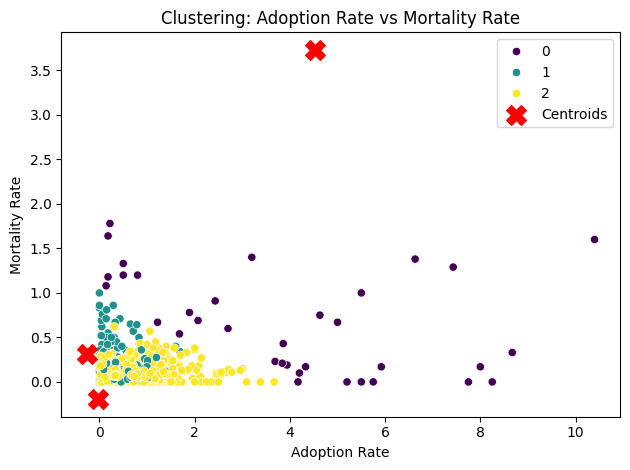

In [ ]:
#5. Clustering with K-Means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Select numerical columns for clustering
features = ['containment_rate', 'mortality_rate', 'adoption_rate']
# Fill missing values with the mean of their respective columns
detailed_data[features] = detailed_data[features].fillna(detailed_data[features].mean())
data_for_clustering = detailed_data[features]



# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
detailed_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Add cluster centroids to visualize
centroids = kmeans.cluster_centers_

# Plot the clustering results
sns.scatterplot(data=detailed_data, x='adoption_rate', y='mortality_rate', hue='Cluster', palette='viridis')
plt.scatter(
    centroids[:, 2], centroids[:, 1],
    s=200, c='red', label='Centroids', marker='X'
)
plt.title('Clustering: Adoption Rate vs Mortality Rate')
plt.xlabel('Adoption Rate')
plt.ylabel('Mortality Rate')
plt.legend()
plt.tight_layout()
plt.show()


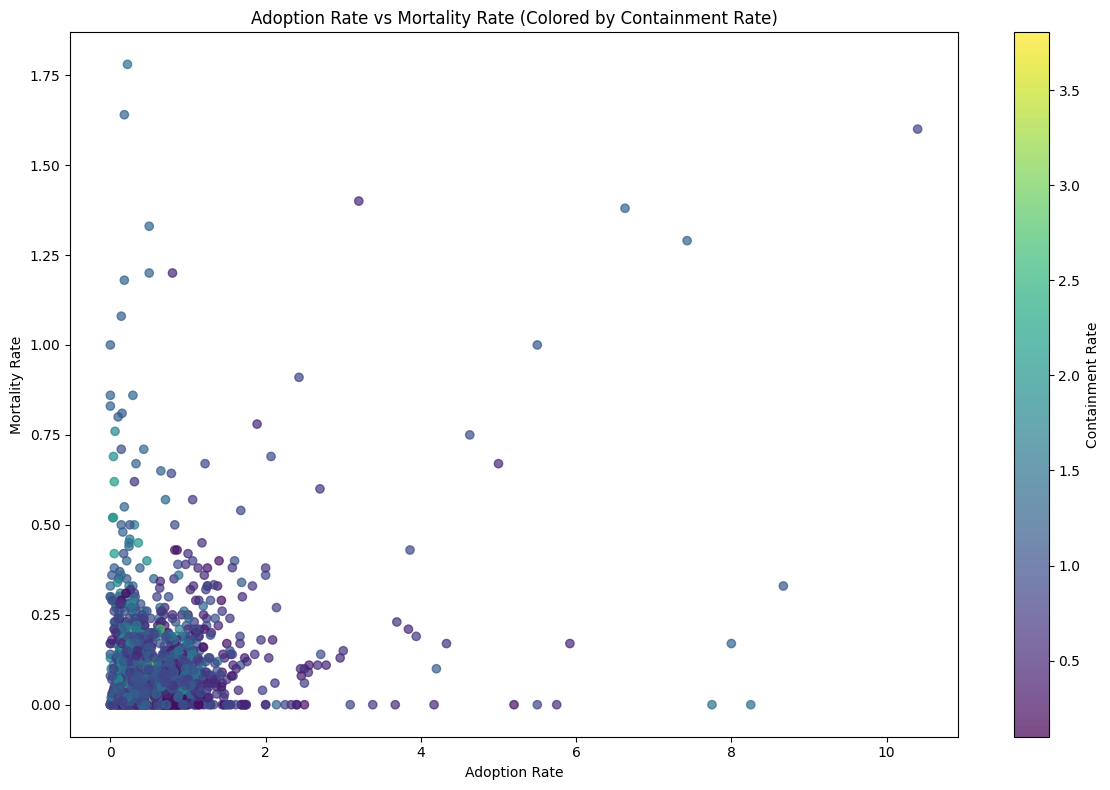

In [ ]:
#6. Advanced Visualizations
#(a) Multivariate Scatter Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    detailed_data['adoption_rate'], detailed_data['mortality_rate'],
    c=detailed_data['containment_rate'], cmap='viridis', alpha=0.7
)
plt.colorbar(scatter, label='Containment Rate')
plt.title('Adoption Rate vs Mortality Rate (Colored by Containment Rate)')
plt.xlabel('Adoption Rate')
plt.ylabel('Mortality Rate')
plt.tight_layout()
plt.show()

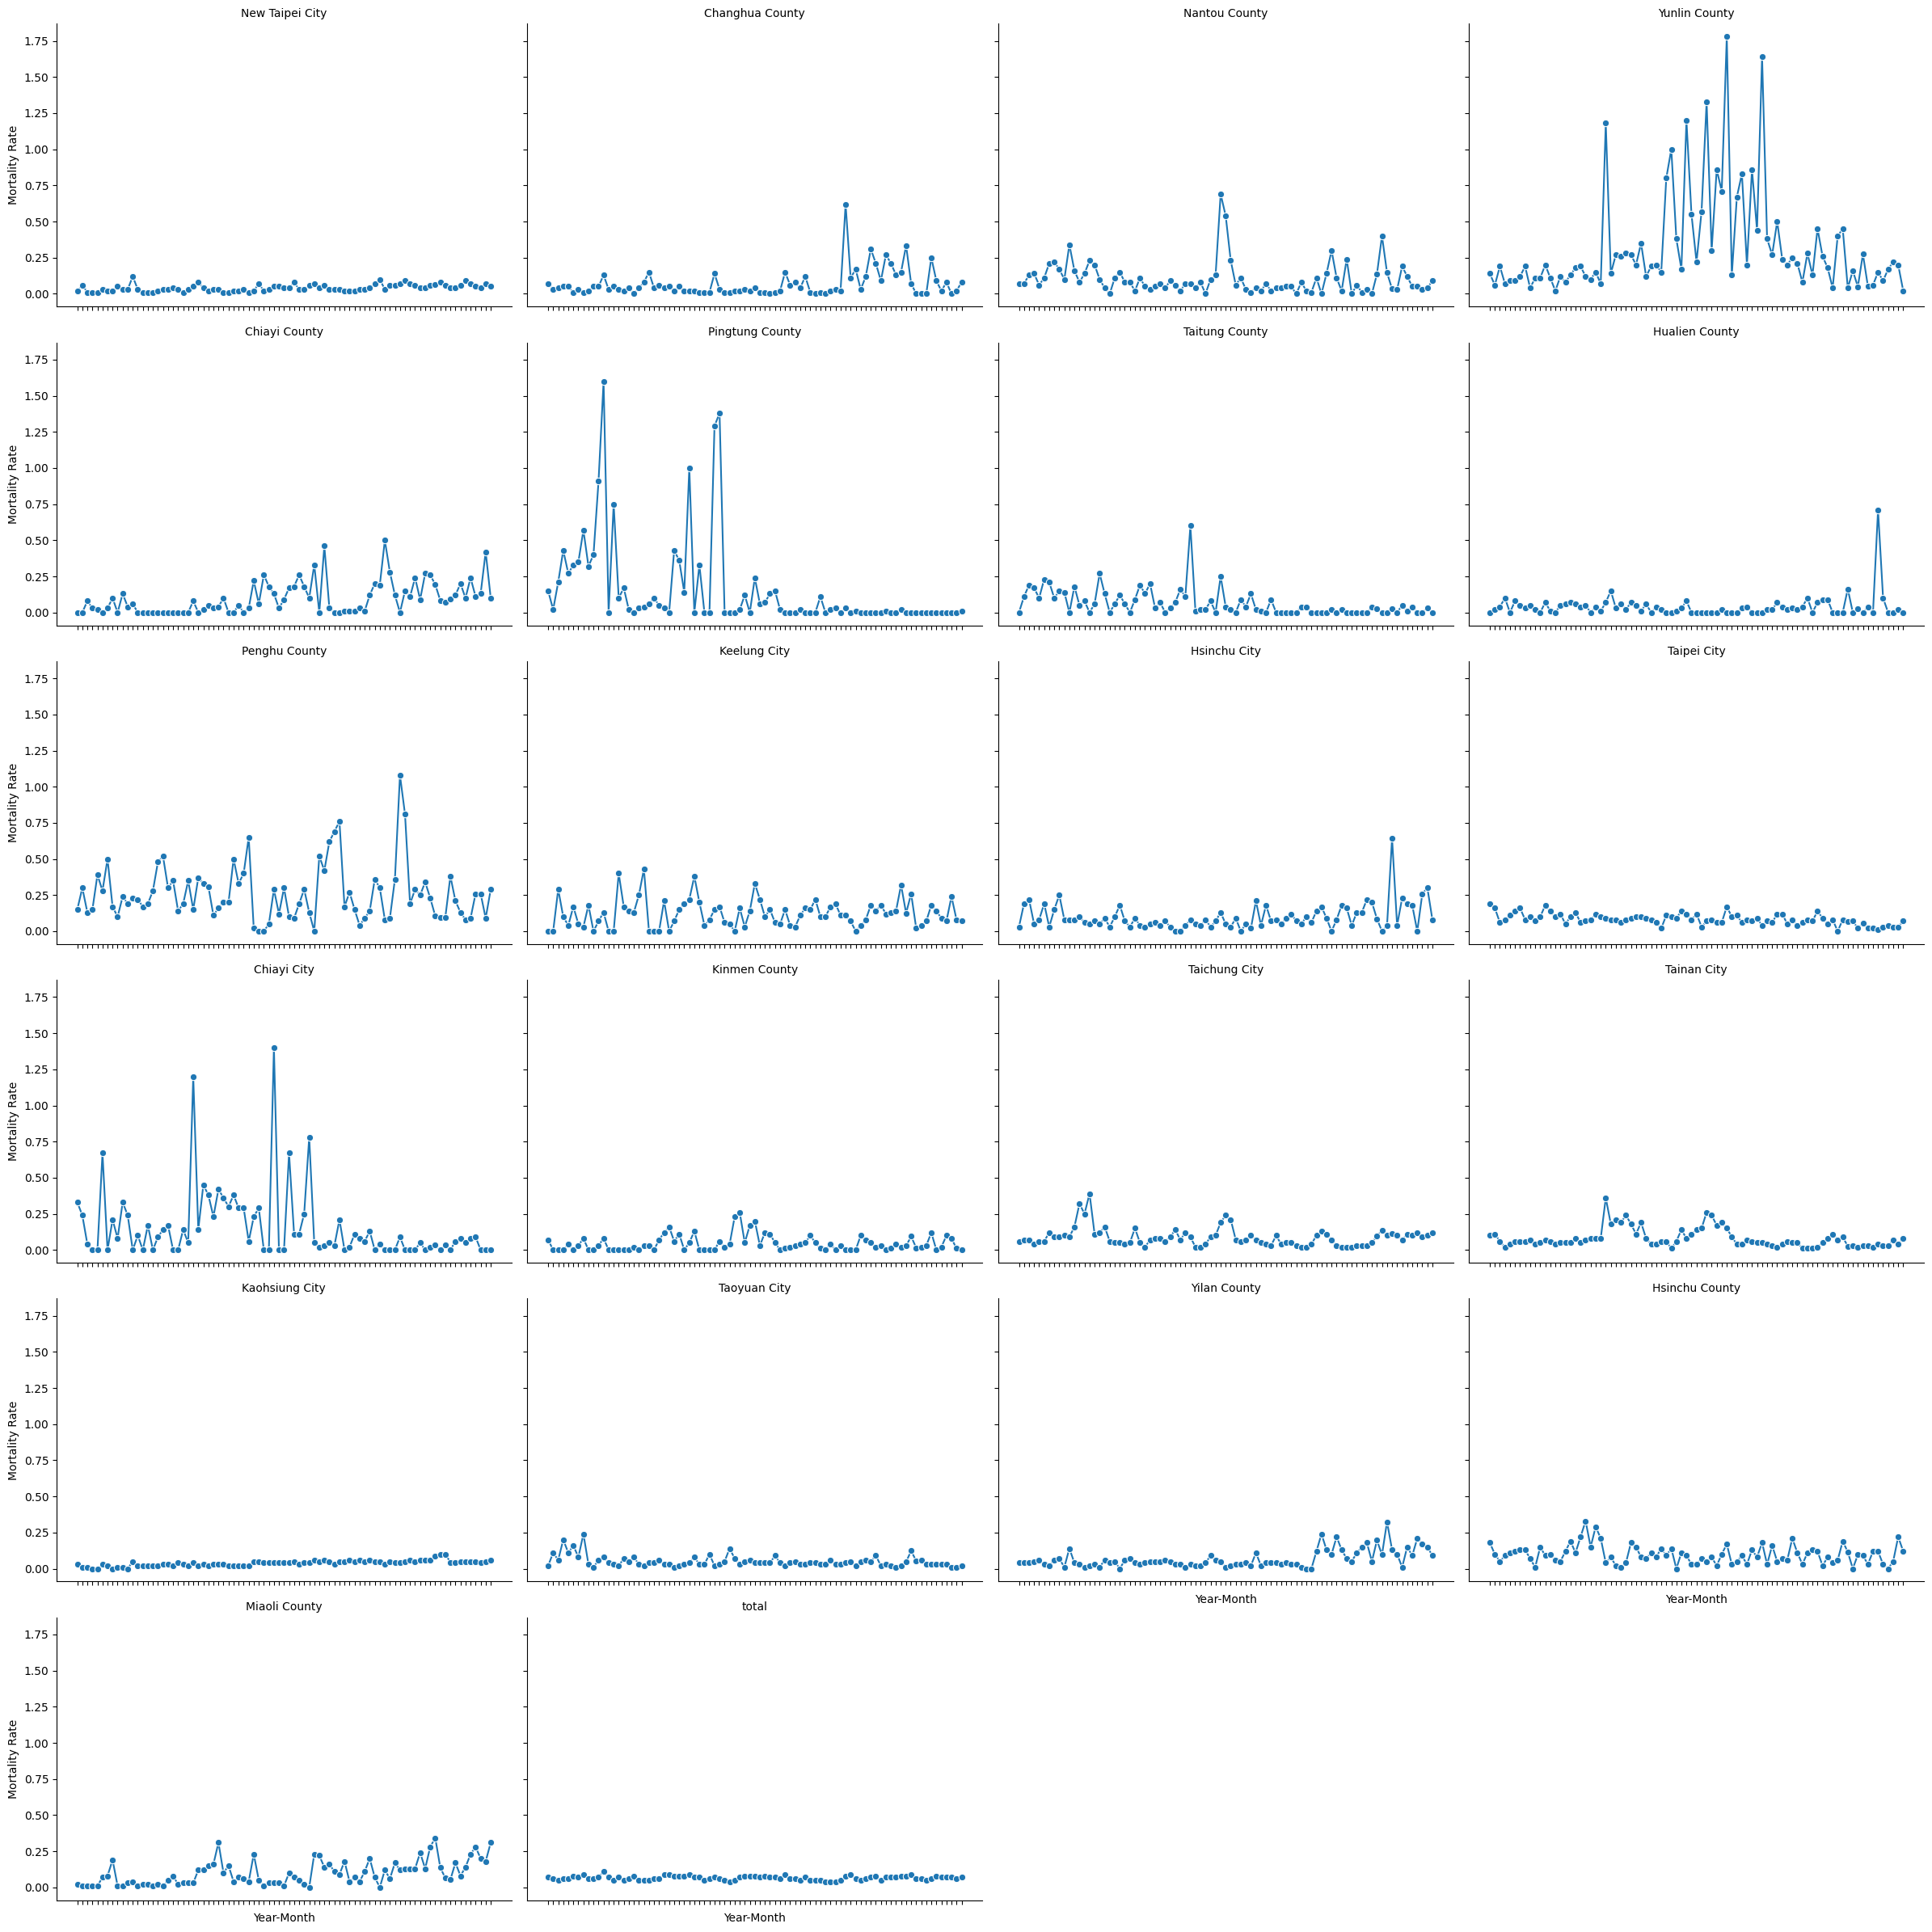

In [ ]:
#(b) Trend Analysis Using Faceting
import seaborn as sns

# Restructure time for easier faceting
detailed_data['Year-Month'] = (
    detailed_data['Year'].astype(str) + '-' + detailed_data['Month'].astype(str).str.zfill(2)
)

# Faceted line chart for each county
g = sns.FacetGrid(detailed_data, col="county_city", col_wrap=4, height=4, aspect=1.5)
g.map(sns.lineplot, "Year-Month", "mortality_rate", marker="o")
g.set_titles("{col_name}")
g.set_axis_labels("Year-Month", "Mortality Rate")
g.set_xticklabels(rotation=45)
g.tight_layout()
plt.show()

###Metrics definitions

In [ ]:
# Define metrics
# Number of animals admitted = the extra number admitted that month
test_data['animals_admitted'] = test_data['containment_rate'] * test_data['adoption_rate'] * 100  # Replace this logic as per actual column definitions

# Adoption Rate
test_data['adoption_rate_percent'] = test_data['adoption_rate'] * 100

# Humane Treatment Rate (Assume we have a column for humane treatments)
test_data['humane_treatment_rate'] = (test_data['euthanasia_rate'] / test_data['containment_rate']) * 100  # Adjust based on actual column names

# Mortality Rate
test_data['mortality_rate_percent'] = test_data['mortality_rate'] * 100

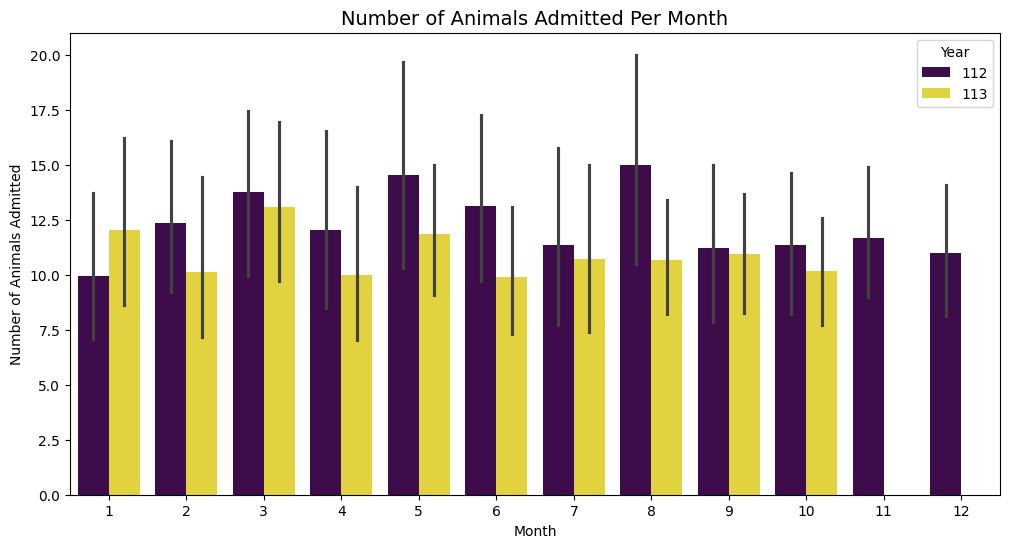

In [ ]:
# 1. Visualization: Number of Animals Admitted Per Month
plt.figure(figsize=(12, 6))
sns.barplot(data=test_data, x='Month', y='animals_admitted', hue='Year', palette="viridis")
plt.title('Number of Animals Admitted Per Month', fontsize=14)
plt.ylabel('Number of Animals Admitted')
plt.xlabel('Month')
plt.legend(title='Year')
plt.show()



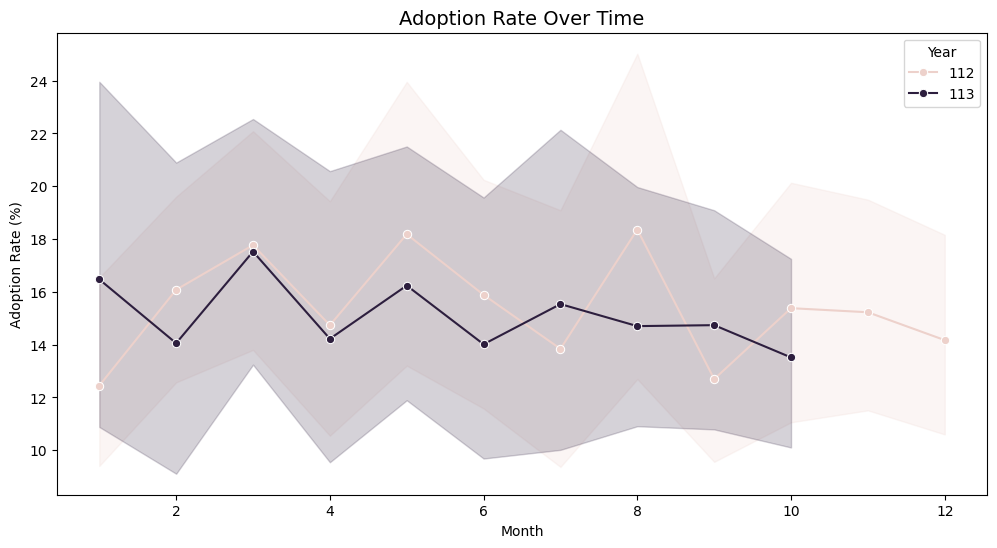

In [ ]:
# 2. Visualization: Adoption Rate Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=test_data, x='Month', y='adoption_rate_percent', hue='Year', marker="o")
plt.title('Adoption Rate Over Time', fontsize=14)
plt.ylabel('Adoption Rate (%)')
plt.xlabel('Month')
plt.legend(title='Year')
plt.show()



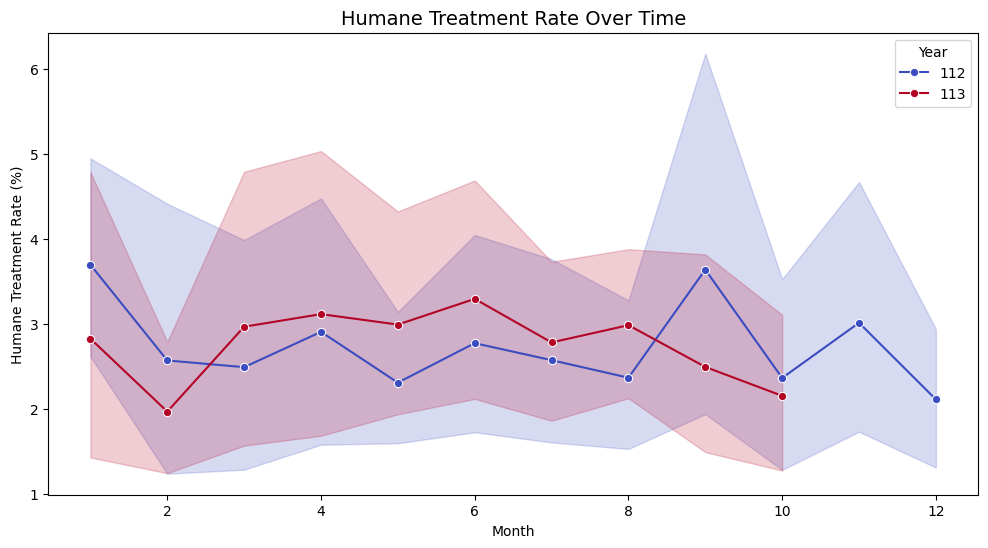

In [ ]:
# 3. Visualization: Humane Treatment Rate Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=test_data, x='Month', y='humane_treatment_rate', hue='Year', marker="o", palette="coolwarm")
plt.title('Humane Treatment Rate Over Time', fontsize=14)
plt.ylabel('Humane Treatment Rate (%)')
plt.xlabel('Month')
plt.legend(title='Year')
plt.show()



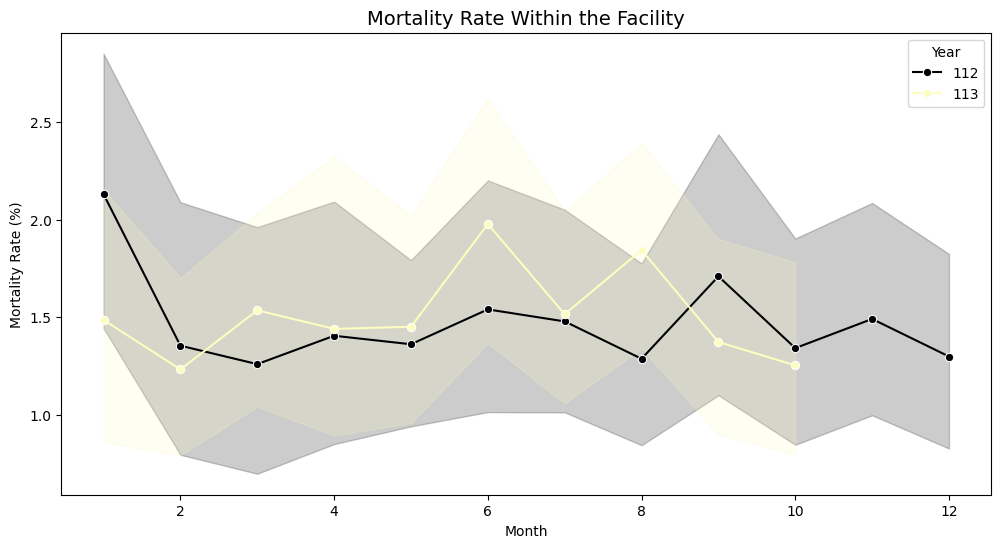

In [ ]:
# 4. Visualization: Mortality Rate Within the Facility
plt.figure(figsize=(12, 6))
sns.lineplot(data=test_data, x='Month', y='mortality_rate_percent', hue='Year', marker="o", palette="magma")
plt.title('Mortality Rate Within the Facility', fontsize=14)
plt.ylabel('Mortality Rate (%)')
plt.xlabel('Month')
plt.legend(title='Year')
plt.show()



---



#Conclusion
###Summary:
 - Containment Rate is a significant factor affecting mortality rates. Efforts should focus on managing shelter capacity, such as:
  - Increasing space and resources for shelters.
  - Promoting adoptions to reduce overpopulation.

- Adoption Rate has a weak and non-significant impact on mortality, suggesting:
 - Adoption activities themselves do not directly contribute to increased mortality.
 - Any minor increase in mortality with higher adoptions might be due to other indirect factors, such as resource strain or disease spread.

Suggestions:
 - Implement strategies to manage containment levels, such as community outreach to prevent stray animal populations and efficient intake policies.
 - Improve health screening and disease control to mitigate risks associated with overcrowding and adoption processes.